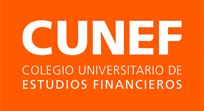

# Máster en Data Science - Machine Learning

# Predicción de fraude mediante el uso de modelos de Machine Learning
##### <font color='dodgerblue' face='Montserrat'>Autor: Rodrigo Fernandez Campos</font>
## DataSet: Bank Account Fraud Dataset Suite (NeurIPS 2022)

# <font size=25><b>Pruebas y experimentos</b></font>

* Pruebas de Modelos
* Pruebas de tamaños de sets con Undersampling
* Pruebas de búsqueda de hiperparámetros

In [1]:
# Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from termcolor import colored, cprint
from sklearn.preprocessing import StandardScaler
import warnings
import sys

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN

from lightgbm.sklearn import LGBMClassifier
import lightgbm



pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

## Funciones

In [2]:
sys.path.append('../src/')
import functions_rfc as fr
sys.path.remove('../src/')

### Constantes:
seed=10

***
# Importo y preparo los datasets

## Importo datasets procesados con anterioridad

In [3]:
df_fraud_train = pd.read_csv('../data/processed/df_train_ready_to_model.csv')
df_fraud_test = pd.read_csv('../data/processed/df_test_ready_to_model.csv')

df_fraud_train.head()

,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,employment_status,credit_risk_score,email_is_free,housing_status,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os_other,device_os_linux,device_os_windows,device_os_macintosh,device_os_x11,keep_alive_session,device_distinct_emails_8w,month,fraud_bool
0,0.8,0.433984,54,9,30,0.020608,49.172739,0.0,954,5137.541683,2712.051960,4240.496920,2,11,0.0,286,0,0.0,0,1,1,1,1000.0,0,0,14.396148,1,0,0,0,0,0,1,6,0
1,0.1,0.712826,-1,97,50,0.024353,-1.091855,1.0,1108,4370.169334,3097.535634,4383.873312,0,6,0.0,132,0,1.0,1,1,28,1,200.0,0,0,4.100053,1,0,0,0,0,0,1,6,0
2,0.4,0.222290,32,115,30,0.002837,-1.067640,2.0,266,7168.731474,2865.219877,4207.649556,0,11,0.0,171,0,4.0,0,1,-1,1,200.0,0,0,2.369306,1,0,0,0,0,0,1,5,0
3,0.7,0.476667,-1,375,40,0.020157,-0.930885,2.0,962,4761.030105,6249.502233,6013.337906,0,8,0.0,245,1,0.0,0,1,-1,1,1500.0,1,0,31.700024,0,1,0,0,0,1,1,1,0
4,0.1,0.506995,11,10,20,0.007662,-0.698526,2.0,874,8823.184279,6315.937497,5653.839202,0,13,3.0,20,0,2.0,0,1,-1,0,200.0,0,0,0.592456,0,1,0,0,0,1,1,2,0


Selecciono solo las variables elegidas en el último procesamiento del notebook anterior:

In [4]:
df_fraud_train_cut = df_fraud_train.drop(['source','velocity_24h','velocity_6h','phone_mobile_valid', 'bank_months_count'], axis=1)
df_fraud_test_cut = df_fraud_test.drop(['source','velocity_24h','velocity_6h','phone_mobile_valid', 'bank_months_count'], axis=1)

df_fraud_train_cut.shape

(700000, 30)

Separo en Train y Test:

In [5]:
X_train_0 = df_fraud_train_cut.drop('fraud_bool', axis=1)
y_train_0 = df_fraud_train_cut['fraud_bool']
X_test = df_fraud_test_cut.drop('fraud_bool', axis=1)
y_test = df_fraud_test_cut['fraud_bool']

## Separación en train y validación estratificado

In [6]:
X_train_1, X_val, y_train_1, y_val = train_test_split(df_fraud_train_cut.drop('fraud_bool',axis=1)
                                                  ,df_fraud_train_cut['fraud_bool']
                                                  ,stratify=df_fraud_train_cut['fraud_bool']
                                                  ,test_size=0.3
                                                  ,random_state=seed)

X_train_complete, X_val_complete, y_train_complete, y_val_complete = train_test_split(df_fraud_train.drop('fraud_bool',axis=1)
                                                                                      ,df_fraud_train['fraud_bool']
                                                                                      ,stratify=df_fraud_train['fraud_bool']
                                                                                      ,test_size=0.3
                                                                                      ,random_state=seed)

In [7]:
X_train_1.shape, X_val.shape, X_train_complete.shape, X_val_complete.shape

((490000, 29), (210000, 29), (490000, 34), (210000, 34))

### Realizo el escalado para utilizar al aplicar el modelo de Regresión Logística

In [8]:
scaler = StandardScaler()
model_scaled = scaler.fit(X_train_1)
X_train_scaled = pd.DataFrame(scaler.transform(X_train_1), columns=X_train_1.columns, index=X_train_1.index)
X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns, index=X_val.index)

X_train_scaled.head() # muestro uno de ejemplo

,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,employment_status,credit_risk_score,email_is_free,housing_status,phone_home_valid,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,device_os_other,device_os_linux,device_os_windows,device_os_macintosh,device_os_x11,keep_alive_session,device_distinct_emails_8w,month
599278,-0.906378,-1.141368,-0.107470,-0.753237,-0.306349,-0.187361,-0.480608,-0.239490,-0.526812,1.239599,4.292476,0.496493,0.308335,0.259751,0.940482,0.180225,-0.846629,-0.535305,-0.030835,-0.161577,-0.337002,-0.721847,1.417951,-0.598906,-0.238795,-0.085935,-1.166552,-0.101765,-0.129402
499849,1.160536,1.227288,-0.402094,0.253942,0.524904,-0.188845,-0.506226,0.793958,1.384972,-0.595162,-0.400956,0.098949,-0.473747,0.302832,-1.063284,-0.607893,1.181155,1.868093,-0.646885,-0.161577,0.428755,-0.721847,-0.705243,-0.598906,4.187688,-0.085935,0.857227,-0.101765,0.775534
345337,-1.595349,1.292729,0.209817,-0.787187,-1.137602,-0.189010,-0.508535,-0.239490,0.148930,-0.242573,-0.396598,1.689126,-0.473747,0.460797,-1.063284,-0.607893,1.181155,-0.535305,-0.010300,-0.161577,-0.332120,1.385334,-0.705243,-0.598906,-0.238795,-0.085935,-1.166552,-0.101765,-0.129402
571314,-1.595349,-0.058074,-0.402094,-0.300572,0.524904,-0.189629,-0.503390,0.793958,-0.220290,0.473835,-0.400956,-0.298595,-0.473747,-0.788563,0.940482,-0.607893,-0.846629,-0.535305,-0.646885,-0.161577,2.296500,1.385334,-0.705243,-0.598906,-0.238795,-0.085935,-1.166552,-0.101765,-1.034339
379586,-0.561893,-0.499498,-0.130133,-0.877720,-0.306349,-0.186727,-0.476766,1.827405,1.479517,1.158247,-0.322514,1.291582,-0.473747,0.776728,0.940482,0.180225,-0.846629,-0.535305,2.022667,-0.161577,-0.130286,1.385334,-0.705243,-0.598906,-0.238795,-0.085935,-1.166552,-0.101765,-0.581871


***
# Unsersampling + Oversampling

Investigando en internet me he topado con una técnica que me parece interesante, que es una combinación proporcional de undersampling y oversampling. He decidido probarlo mediante la aplicación de un Pipeline en donde se aplican secuencialmente las técnicas.

Me parece una aplicación acertada para casos como el de este dataset en donde los datos están extremadamente desbalanceados, al punto de que un undersampling aplicado directamente eliminaría una cantidad demasiado alta de información, mientras que un oversampling podría generar un sesgo por la cantidad enorme de datos sintéticos a generar. Es por eso que un acercamiento entre ambos parece una solución interesante, al menos sobre el papel.

Existen dentro de Imbalanced-Learning de SKL dos funciones con una combinación interna de oversampling y undersampling, pero al probarlas no parecen estar optimizadas y el costo computacional que me requieren es demasiado alto, por eso generaré y aplicaré mi propio Pipeline manualmente.

Entonces, para lidiar con el desbalanceo terminaré aplicando:

1. Split estatificado (SE) --> (realizado en Notebook 02)
2. RandomUnderSampling
3. SMOTE OverSampling
4. Pipeline con sampling mix --> (SMOTE OverSampling + Random UnderSampling)


In [9]:
# El tamaño y distribución actual del DataSet de train son los siguientes:
X_train_1.shape,y_train_1.value_counts(),y_train_1.value_counts(normalize=True)

((490000, 29),
 fraud_bool
 0    484596
 1      5404
 Name: count, dtype: int64,
 fraud_bool
 0    0.988971
 1    0.011029
 Name: proportion, dtype: float64)

#### 1. Random Undersampling

In [10]:
undersamp = RandomUnderSampler(sampling_strategy=0.08, random_state=seed)
X_train_under, y_train_under = undersamp.fit_resample(X_train_1, y_train_1)

In [11]:
X_train_under.shape,y_train_under.value_counts(),y_train_under.value_counts(normalize=True)

((72954, 29),
 fraud_bool
 0    67550
 1     5404
 Name: count, dtype: int64,
 fraud_bool
 0    0.925926
 1    0.074074
 Name: proportion, dtype: float64)

In [12]:
1 - X_train_under.shape[0] / X_train_1.shape[0]

0.8511142857142857

Logramos el cometido, el dataset está balanceado, pero solo nos quedamos con 27k datos, es decir que perdimos el 94% de nuestro dataset, 
dato que es al menos recalcable. Habrá que ver como funcionan los modelos con una reducción tan grande del dataset.

### Realizo el escalado para utilizar al aplicar el modelo de Regresión Logística

In [6]:
scaler = StandardScaler()
model_scaled = scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

model_scaled = scaler.fit(X_train_cut)
X_train_cut_scaled = pd.DataFrame(scaler.transform(X_train_cut), columns=X_train_cut.columns, index=X_train_cut.index)
X_test_cut_scaled = pd.DataFrame(scaler.transform(X_test_cut), columns=X_test_cut.columns, index=X_test_cut.index)

model_scaled = scaler.fit(X_train_samp)
X_train_samp_scaled = pd.DataFrame(scaler.transform(X_train_samp), columns=X_train_samp.columns, index=X_train_samp.index)

# Recuerdo que el test nunca se toca en cuanto a undersampling u oversampling se refiere. Solo el train

X_train_cut_scaled.head() # muestro uno de ejemplo

,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,intended_balcon_amount,payment_type,zip_count_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,employment_status,credit_risk_score,email_is_free,housing_status,phone_home_valid,phone_mobile_valid,has_other_cards,proposed_credit_limit,foreign_request,device_os_linux,device_os_windows,device_os_macintosh,keep_alive_session,device_distinct_emails_8w
0,0.816970,-0.206759,0.844254,-0.877809,-0.306848,2.001320,-1.273961,-0.615428,-0.396667,0.297512,-0.473560,2.226026,-1.061572,-1.395809,-0.846388,0.352477,1.866506,0.994196,-0.161050,-0.705863,-0.598102,-0.238849,-1.166863,-0.101505
1,-1.594075,0.757666,-0.402385,0.117574,1.355648,-0.482436,-0.240130,-0.462261,-0.401022,-0.696188,-0.473560,0.014195,-1.061572,-0.607574,1.181492,0.352477,1.866506,-0.647578,-0.161050,-0.705863,-0.598102,-0.238849,-1.166863,-0.101505
2,-0.560770,-0.938937,0.345598,0.321175,-0.306848,-0.481239,0.793702,-1.299705,-0.401022,0.297512,-0.473560,0.574334,-1.061572,1.757131,-0.846388,0.352477,1.866506,-0.647578,-0.161050,-0.705863,-0.598102,-0.238849,-1.166863,-0.101505
3,0.472535,-0.059132,-0.402385,3.262080,0.524400,-0.474482,0.793702,-0.607471,-0.401022,-0.298708,-0.473560,1.637162,0.941999,-1.395809,-0.846388,0.352477,1.866506,2.020305,6.209245,1.416705,-0.598102,-0.238849,0.856998,-0.101505
4,-1.594075,0.045763,-0.130391,-0.866497,-1.138096,-0.463000,0.793702,-0.694995,-0.401022,0.694992,1.870709,-1.594410,-1.061572,0.180661,-0.846388,0.352477,-0.535760,-0.647578,-0.161050,1.416705,-0.598102,-0.238849,0.856998,-0.101505


# Modelos

## 1. Decision Tree

In [7]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
tree.fit(X_train,y_train)

DecisionTreeClassifier()

In [8]:
tree.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [9]:
from sklearn.metrics import accuracy_score
accuracy_score(tree.predict(X_test),y_test)

0.97741

In [10]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(tree.predict(X_test),y_test)
cf_matrix

array([[292885,   2971],
       [  3806,    338]], dtype=int64)

In [13]:
tree2 = DecisionTreeClassifier()
tree2.fit(X_train_cut,y_train)

DecisionTreeClassifier()

In [14]:
accuracy_score(tree2.predict(X_test_cut),y_test)

0.9771666666666666

In [17]:
confusion_matrix(tree2.predict(X_test_cut),y_test)

array([[292813,   2972],
       [  3878,    337]], dtype=int64)

In [24]:
tree3 = DecisionTreeClassifier()
tree3.fit(X_train_samp,y_train_samp)

DecisionTreeClassifier()

In [29]:
accuracy_score(tree3.predict(X_test_cut),y_test)

0.9575233333333333

In [31]:
confusion_matrix(tree3.predict(X_test_cut),y_test)

array([[286604,   2656],
       [ 10087,    653]], dtype=int64)

In [ ]:
%% time
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
import statsmodels.formula.api as smf

classifiers = [
    DummyClassifier()
    ,LogisticRegression()
    ,GaussianNB()
    ,DecisionTreeClassifier()
    ,smf.glm() # https://medium.com/@sarka.pribylova/generalized-linear-model-f607ac7f0ef5
    ,RandomForestClassifier()
    #,XGBoost()
    ]

for classifier in classifiers:
    pipe = Pipeline(steps=[('classifier', classifier)])
    pipe.fit(X_train, y_train)   
    accuracy = accuracy_score(pipe.predict(X_test),y_val)
    f1 = 
    c_matrix = 
    print(classifier)
    print("model score: %.3f" % pipe.score(X_test, y_val))

# Voy a hacer este pipe para elegir modelo, dsps un for con modelos elegidos tmb sin hiperparams entre los 3 datasets (revisar seleccion de variables) para ver cual es el que
# da mejor, y recién ahí, con el modelo y el dataset elegido voy a ejecutar, buscar hiperparámetros... Lo hago con el GRID o RANDOM con la CV (viene en la función)

In [11]:
lr = LogisticRegression()

LogisticRegression()

In [18]:
lr.fit(X_train_scaled,y_train)

LogisticRegression()

In [19]:
lr.predict(X_test_scaled)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [14]:
accuracy_score(lr.predict(X_test),y_test)

0.98897

In [26]:
from sklearn.metrics import balanced_accuracy_score,average_precision_score, precision_recall_curve, roc_curve, auc, recall_score, precision_score, confusion_matrix, f1_score,\
fbeta_score

In [24]:
precision_score(lr.predict(X_test_scaled),y_test), recall_score(lr.predict(X_test_scaled),y_test), f1_score(lr.predict(X_test_scaled),y_test)

(0.0075551526140828044, 0.625, 0.014929829799940283)

In [25]:
confusion_matrix(lr.predict(X_test_scaled),y_test)

array([[296676,   3284],
       [    15,     25]], dtype=int64)

In [27]:
fbeta_score(lr.predict(X_test_scaled),y_test, beta=2)

0.036033439031421165